In [1]:
import torch
import torchvision
from torch import nn, functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import time
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
def evaluate_model(y_true = None, y_predict = None, cls_names = None):
    print('Model Evaluation')
    print('======================')
    print(f'Accuracy Score: {accuracy_score(y_true, y_predict) * 100:.2f}%')
    print(f'Precision Score: {precision_score(y_true, y_predict, average="macro") * 100:.2f}%')
    print(f'Recall Score: {recall_score(y_true, y_predict, average="macro") * 100:.2f}%')
    print(f'F1 Score: {f1_score(y_true, y_predict, average="macro") * 100:.2f}%')
    print(f'Classification Report: \n {classification_report(y_true, y_predict, target_names=cls_names)}')
    plt.figure(figsize = [8, 7])
    plt.title('Confusion Matrix')
    sns.heatmap(confusion_matrix(y_true, y_predict), fmt = 'd', annot = True, xticklabels = cls_names, yticklabels = cls_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
# End Func

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
composed_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_data = torchvision.datasets.CIFAR10(root='./data_cifer', train = True, download=True, transform=transforms.ToTensor())
test_data = torchvision.datasets.CIFAR10(root='./data_cifer', train = False, download=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [6]:
# Hyperparamters
batch_size = 100
learning_rate = 0.001
num_epochs = 20

In [7]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [8]:
n_classes = len(train_data.classes)
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

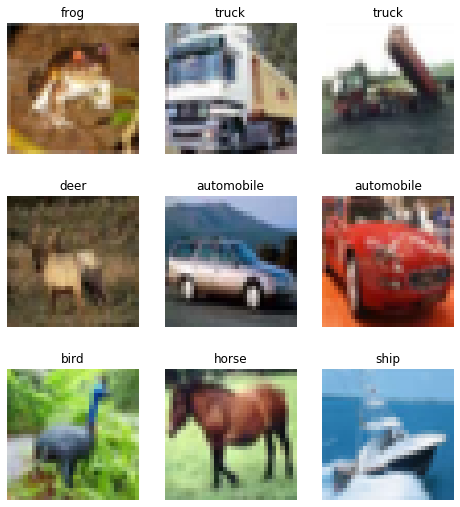

In [9]:
disp_len = 9
ex_imgs, ex_lbls = train_data.data[:disp_len], train_data.targets[:disp_len]
plt.figure(figsize=[8, 9])
for i  in range(disp_len):
    plt.subplot(3, 3, i + 1)
    plt.title(train_data.classes[ex_lbls[i]])
    plt.imshow(ex_imgs[i])
    plt.axis(False)
# End For 

In [10]:
class ConvNet(nn.Module):
    def __init__(self, output_dim = None):
        super(ConvNet, self).__init__()
        self.conv_layer_1 =  nn.Conv2d(3, 8, 3, padding='same')
        self.batch_norm_1 = nn.BatchNorm2d(8)
        
        self.conv_layer_2 = nn.Conv2d(8, 16, 3, padding='same')
        self.batch_norm_2 = nn.BatchNorm2d(16)

        self.conv_layer_3 = nn.Conv2d(16, 32, 3, padding='same')
        self.batch_norm_3 = nn.BatchNorm2d(32)
        
        self.conv_layer_4 = nn.Conv2d(32, 64, 3, padding='same')
        self.batch_norm_4 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.fc_layer_1 = nn.Linear(256, 256)
        self.fc_layer_out = nn.Linear(256, output_dim)
    # End Func
    
    def ConvNetModelBackbone(self, input):
        # Block [1]
        block_1 = self.conv_layer_1(input)
        block_1 = self.batch_norm_1(block_1)
        block_1 = self.relu(block_1)
        block_1 = self.pool(block_1)
        
        # Block [2]
        block_2 = self.conv_layer_2(block_1)
        block_2 = self.batch_norm_2(block_2)
        block_2 = self.relu(block_2)
        block_2 = self.pool(block_2)

        # Block [3]
        block_3 = self.conv_layer_3(block_2)
        block_3 = self.batch_norm_3(block_3)
        block_3 = self.relu(block_3)
        block_3 = self.pool(block_3)

        # Block [4]
        block_4 = self.conv_layer_4(block_3)
        block_4 = self.batch_norm_4(block_4)
        block_4 = self.relu(block_4)
        block_4 = self.pool(block_4)
        
        # Fully Connected
        flatten_out = self.flatten(block_4)
        fc_out = self.fc_layer_1(flatten_out)
        fc_out = self.fc_layer_out(fc_out)
        return fc_out
    # End Func
    
    def forward(self, input):
        output = self.ConvNetModelBackbone(input)
        return output
    # End Func
# End Class

In [11]:
convNetModel = ConvNet(output_dim = n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convNetModel.parameters(), lr = learning_rate)
num_steps = len(train_loader)
train_loss = []

In [16]:
print(convNetModel)

ConvNet(
  (conv_layer_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_layer_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_layer_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_layer_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layer_1): Linear(in_features=256, out_features=256, bias=True)
  (fc_layer_out): Linear(in_features=256, out_features=10,

In [12]:
for epoch in range(num_epochs):
    for step, (X_batch, y_true) in enumerate(train_loader):
        y_hat = convNetModel(X_batch)
        loss = criterion(y_hat, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        end = '\r' if (step + 1) % num_steps else '\n'
        print(f"Epochs: [{epoch + 1}/{num_epochs}], Steps: [{step + 1}/{num_steps}], Loss = {loss.item():.4f}", end = end, flush=True)
    # End For
    train_loss.append(loss.item())
# End For

Epochs: [1/20], Steps: [500/500], Loss = 1.2354
Epochs: [2/20], Steps: [500/500], Loss = 1.0795
Epochs: [3/20], Steps: [500/500], Loss = 1.0003
Epochs: [4/20], Steps: [500/500], Loss = 0.9610
Epochs: [5/20], Steps: [500/500], Loss = 0.8299
Epochs: [6/20], Steps: [500/500], Loss = 0.7199
Epochs: [7/20], Steps: [500/500], Loss = 0.9213
Epochs: [8/20], Steps: [500/500], Loss = 0.7522
Epochs: [9/20], Steps: [500/500], Loss = 0.7522
Epochs: [10/20], Steps: [500/500], Loss = 0.6815
Epochs: [11/20], Steps: [500/500], Loss = 0.6023
Epochs: [12/20], Steps: [500/500], Loss = 0.5024
Epochs: [13/20], Steps: [500/500], Loss = 0.4969
Epochs: [14/20], Steps: [500/500], Loss = 0.5140
Epochs: [15/20], Steps: [500/500], Loss = 0.4189
Epochs: [16/20], Steps: [500/500], Loss = 0.5621
Epochs: [17/20], Steps: [500/500], Loss = 0.6756
Epochs: [18/20], Steps: [500/500], Loss = 0.4162
Epochs: [19/20], Steps: [500/500], Loss = 0.4438
Epochs: [20/20], Steps: [500/500], Loss = 0.4535


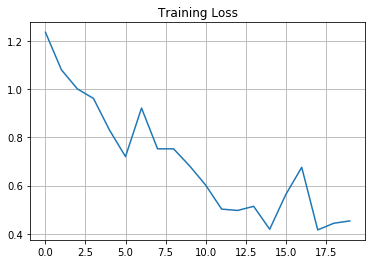

In [13]:

plt.title('Training Loss')
plt.plot(train_loss)
plt.grid()
plt.show()

In [14]:
# prepare and load test data
test_loader = DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)
X_test, y_test = iter(test_loader).next()

Model Evaluation
Accuracy Score: 70.50%
Precision Score: 70.48%
Recall Score: 70.50%
F1 Score: 70.31%
Classification Report: 
               precision    recall  f1-score   support

    airplane       0.73      0.71      0.72      1000
  automobile       0.81      0.85      0.83      1000
        bird       0.62      0.57      0.60      1000
         cat       0.51      0.51      0.51      1000
        deer       0.73      0.61      0.66      1000
         dog       0.62      0.59      0.61      1000
        frog       0.69      0.82      0.75      1000
       horse       0.71      0.81      0.76      1000
        ship       0.81      0.84      0.82      1000
       truck       0.82      0.74      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



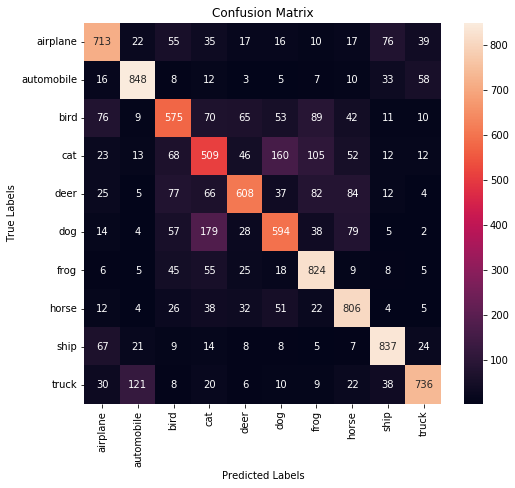

In [15]:
with torch.no_grad():
    _, y_predict = convNetModel(X_test).max(axis = 1)
    evaluate_model(y_true = y_test, y_predict = y_predict, cls_names = train_data.classes)
# End With